# Import Libraries


In [3]:
import h5py as h5py
import torch
import numpy as np
from torch.nn.parameter import Parameter
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
from google.colab import files

%matplotlib inline

# Dataset

## Load Dataset

In [4]:
# Download the dataset
if not os.path.isfile('MNIST_synthetic.zip'):
    ! gdown https://drive.google.com/uc?id=1LcKqf1d7bctw5lx0YZf31kCUF0zEYOsi
    ! unzip MNIST_synthetic.zip
    print('Downloaded and unzipped')
else:
    print('Already Downloaded!')

Downloading...
From: https://drive.google.com/uc?id=1LcKqf1d7bctw5lx0YZf31kCUF0zEYOsi
To: /content/MNIST_synthetic.zip
15.9MB [00:00, 96.9MB/s]
Archive:  MNIST_synthetic.zip
  inflating: MNIST_synthetic.h5      
Downloaded and unzipped


In [5]:
train_split = 0.8
torch.random.seed = 0

f = h5py.File('MNIST_synthetic.h5', 'r')
X_all = torch.tensor(f['train_dataset'][...]).permute(0, 3, 1, 2).contiguous()
y_all = torch.tensor(f['train_labels'][...])
randinds = torch.randperm(len(X_all))
split_ind = int(train_split * len(X_all))

X_train = X_all[randinds[:split_ind]]
y_train = y_all[randinds[:split_ind]]
X_val = X_all[randinds[split_ind:]]
y_val = y_all[randinds[split_ind:]]
X_test = torch.tensor(f['test_dataset'][...]).permute(0, 3, 1, 2).contiguous()

print(f'X_train.shape: {X_train.shape}, dtype {X_train.dtype}')
print(f'y_train.shape: {y_train.shape}, dtype {y_train.dtype}')
print('---')
print(f'X_val.shape: {X_val.shape}, dtype {X_val.dtype}')
print(f'y_val.shape: {y_val.shape}, dtype {y_val.dtype}')
print('---')
print(f'X_test.shape: {X_test.shape}, dtype {X_test.dtype}')

X_train.shape: torch.Size([44800, 1, 64, 64]), dtype torch.uint8
y_train.shape: torch.Size([44800, 5]), dtype torch.int32
---
X_val.shape: torch.Size([11200, 1, 64, 64]), dtype torch.uint8
y_val.shape: torch.Size([11200, 5]), dtype torch.int32
---
X_test.shape: torch.Size([14000, 1, 64, 64]), dtype torch.uint8


## Preprocess Data


In [6]:
def scale(tensor):
    """
    [0, 255] -> [-1, 1]
    """
    return (tensor.to(torch.float32) * 2 / 255) - 1

def descale(tensor):
    """
    [-1, 1] -> [0, 255]
    """
    return ((tensor + 1) * 255 / 2).to(torch.uint8)

def visualize_tensor(tensor):
    """
    visualize a tensor. Must be in range [-1, 1] or [0, 255].
    """
    if tensor.dtype == torch.float32:
        tensor = descale(tensor)
    array = tensor.squeeze().numpy()
    plt.imshow(array, cmap='Greys_r')
    plt.show()


In [7]:
digit_size = 12  # 64 // 5
crop_h_start = (64 // 2) - (digit_size // 2)
crop_h_end = crop_h_start + digit_size +1  # +1 is safety margin
crop_w_start = 2
crop_w_end = -2

def split_digits(tensor, num_digits, digit_size=digit_size):
    """
    splits a single image of `num_digits` digits to multiple images
    """
    start_index = (5 - num_digits) * digit_size // 2
    end_index = start_index + (num_digits * digit_size)
    tensor = tensor[..., start_index: end_index]
    return torch.stack(torch.chunk(tensor, num_digits, dim=2))

# remove padding and rescale
X_train_processed = scale(X_train[..., crop_h_start: crop_h_end, crop_w_start: crop_w_end])
y_train_processed = y_train.to(torch.int64)
X_val_processed = scale(X_val[..., crop_h_start: crop_h_end, crop_w_start: crop_w_end])
y_val_processed = y_val.to(torch.int64)
X_test_processed = scale(X_test[..., crop_h_start: crop_h_end, crop_w_start: crop_w_end])

X_train1 = X_train_processed
y_train1 = (y_train_processed != 10).sum(axis=1) - 1
X_val1 = X_val_processed
y_val1 = (y_val_processed != 10).sum(axis=1) - 1

print(f'X_train1.shape: {X_train1.shape}, dtype {X_train1.dtype}')
print(f'y_train1.shape: {y_train1.shape}, dtype {y_train1.dtype}')
print('---')
print(f'X_val1.shape: {X_val1.shape}, dtype {X_val1.dtype}')
print(f'y_val1.shape: {y_val1.shape}, dtype {y_val1.dtype}')

X_train1.shape: torch.Size([44800, 1, 13, 60]), dtype torch.float32
y_train1.shape: torch.Size([44800]), dtype torch.int64
---
X_val1.shape: torch.Size([11200, 1, 13, 60]), dtype torch.float32
y_val1.shape: torch.Size([11200]), dtype torch.int64


In [8]:
X_train2 = []
for i in range(len(X_train1)):
    X_train2.append(split_digits(X_train1[i], y_train1[i] + 1))
X_train2 = torch.cat(X_train2, 0)
y_train2 = y_train[y_train != 10].to(torch.long)
X_val2 = []
for i in range(len(X_val1)):
    X_val2.append(split_digits(X_val1[i], y_val1[i] + 1))
X_val2 = torch.cat(X_val2, 0)
y_val2 = y_val[y_val != 10].to(torch.long)

print(f'X_train2.shape: {X_train2.shape}, dtype {X_train2.dtype}')
print(f'y_train2.shape: {y_train2.shape}, dtype {y_train2.dtype}')
print('---')
print(f'X_val2.shape: {X_val2.shape}, dtype {X_val2.dtype}')
print(f'y_val2.shape: {y_val2.shape}, dtype {y_val2.dtype}')

X_train2.shape: torch.Size([134333, 1, 13, 12]), dtype torch.float32
y_train2.shape: torch.Size([134333]), dtype torch.int64
---
X_val2.shape: torch.Size([33553, 1, 13, 12]), dtype torch.float32
y_val2.shape: torch.Size([33553]), dtype torch.int64


torch.Size([134333, 1, 13, 12])
torch.Size([134333])
------

Preprocessed X_train2
Label: 9


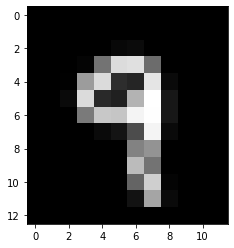

In [9]:
print(X_train2.shape)
print(y_train2.shape)
print('------\n')
print('Preprocessed X_train2')
ind = np.random.choice(len(y_train2))
print(f'Label: {y_train2[ind]}')
visualize_tensor(X_train2[ind])

Raw X_train


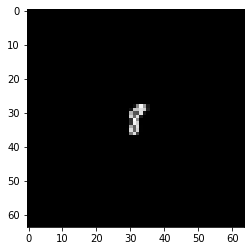

------

Preprocessed X_train1
Label+1: 3


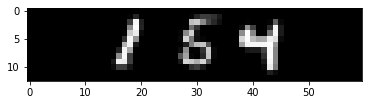

Splitted


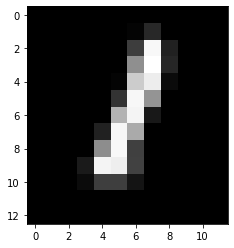

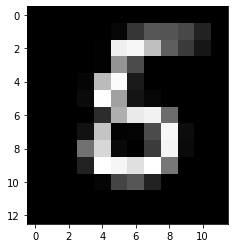

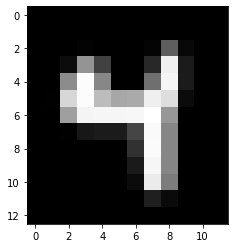

Preprocessed X_val1
Label+1: 4


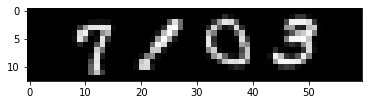

Splitted


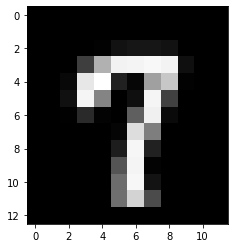

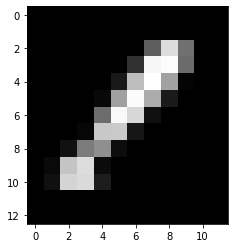

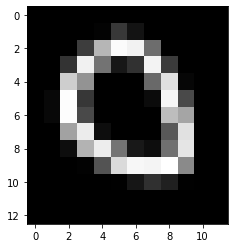

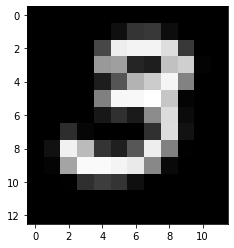

In [10]:
print('Raw X_train')
visualize_tensor(X_train[102])
print('------\n')
print('Preprocessed X_train1')
ind = np.random.choice(len(y_train1))
print(f'Label+1: {y_train1[ind] + 1}')
visualize_tensor(X_train1[ind])
print('Splitted')
splitted_digits = split_digits(X_train1[ind], y_train1[ind] + 1)
for digit in splitted_digits:
    visualize_tensor(digit)
print('Preprocessed X_val1')
ind = np.random.choice(len(y_val1))
print(f'Label+1: {y_val1[ind] + 1}')
visualize_tensor(X_val1[ind])
print('Splitted')
splitted_digits = split_digits(X_val1[ind], y_val1[ind] + 1)
for digit in splitted_digits:
    visualize_tensor(digit)

# Convolutional neural networks :


In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def train_model(model, train_loader, val_loader, iter_range=1000, device=device, print_freq=100):
    model.train()
    model.to(device)
    running_loss = 0
    num_samples = 0
    num_correct = 0
    train_iter = iter(train_loader)
    for i in range(iter_range):
        try:
            inputs, labels = next(train_iter) 
        except StopIteration:
            train_iter = iter(train_loader)
            inputs, labels = next(train_iter) 
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # computing gradients wrt model's weights
        optimizer.step() # update using learning rate

        # statistics
        running_loss += loss.item() * len(inputs)
        num_correct += (outputs.argmax(-1) == labels).sum().float().item()
        num_samples += len(inputs)
        if i % print_freq == print_freq - 1:
            model.eval()
            val_running_loss = 0
            val_correct = 0
            num_val = 0
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * len(inputs)
                val_correct += (outputs.argmax(-1) == labels).sum().float()
                num_val += len(inputs)
            msg = f'iteration {i + 1}, train: loss {running_loss / num_samples:.4f}, '
            msg += f'acc {num_correct / num_samples:.4f}; '
            msg += f'val: loss {val_running_loss / num_val:.4f}, val acc {val_correct / num_val:.4f}'
            print(msg)
            running_loss = 0
            num_correct = 0
            num_samples = 0
            model.train()
        if i >= iter_range:
            break
    print('Done')

#Predict number of digits in each sample

In [12]:
# STEP 1
# Train a NN to predict num_digits in each sample.
# This model should have accuracy very close to 100% (>99% on validation)

mlp_size = [512, 128, 5]
model1 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 64, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=64,
                    out_channels=64,
                    kernel_size=3,
                    padding=0),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(832, mlp_size[1]),
    torch.nn.BatchNorm1d(mlp_size[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(mlp_size[1], mlp_size[2]),
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())  # converges faster and less sensitive to lr, generalizes (typiaclly) worse

batch_size = 4
train1_dataset = TensorDataset(X_train1, y_train1)
val1_dataset = TensorDataset(X_val1, y_val1)
train1_loader = torch.utils.data.DataLoader(train1_dataset, batch_size=batch_size)
val1_loader = torch.utils.data.DataLoader(val1_dataset, batch_size=batch_size)
train_model(model1, train1_loader, val1_loader)

def predict_num_digits(tensor):
    assert tensor.shape[-3:] == (1, 13, 60), "incorrect tensor size"
    model1.eval()
    if tensor.ndim == 3:
        predictions = model1(tensor.unsqueeze(0).to(device)).argmax(-1).squeeze()
    else:
        predictions = model1(tensor.to(device)).argmax(-1)
    model1.train()
    return predictions + 1

iteration 100, train: loss 0.4526, acc 0.9075; val: loss 0.0526, val acc 0.9999
iteration 200, train: loss 0.1881, acc 0.9650; val: loss 0.0109, val acc 1.0000
iteration 300, train: loss 0.1109, acc 0.9925; val: loss 0.0067, val acc 1.0000
iteration 400, train: loss 0.0896, acc 0.9875; val: loss 0.0059, val acc 1.0000
iteration 500, train: loss 0.1077, acc 0.9775; val: loss 0.0047, val acc 1.0000
iteration 600, train: loss 0.0573, acc 0.9950; val: loss 0.0026, val acc 1.0000
iteration 700, train: loss 0.0790, acc 0.9825; val: loss 0.0040, val acc 1.0000
iteration 800, train: loss 0.0704, acc 0.9850; val: loss 0.0020, val acc 1.0000
iteration 900, train: loss 0.1940, acc 0.9500; val: loss 0.0022, val acc 1.0000
iteration 1000, train: loss 0.0956, acc 0.9825; val: loss 0.0027, val acc 1.0000
Done


Preprocessed X_test_processed
torch.Size([14000, 1, 13, 60])


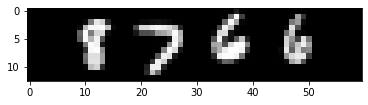

tensor(4, device='cuda:0')
Splitted


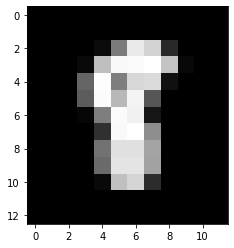

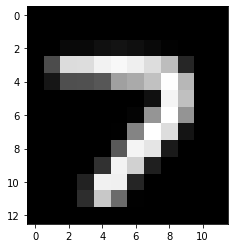

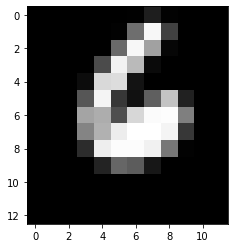

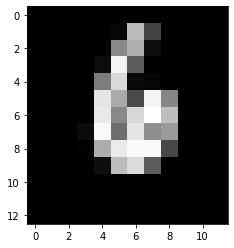

In [13]:
print('Preprocessed X_test_processed')
print(X_test_processed.shape)
ind = np.random.choice(len(X_test_processed))
visualize_tensor(X_test_processed[ind])
print(predict_num_digits(X_test_processed[ind]))
print('Splitted')
model1.eval()
splitted_digits = split_digits(X_test_processed[ind], predict_num_digits(X_test_processed[ind]))
for digit in splitted_digits:
    visualize_tensor(digit)

#Predit Digits

In [14]:
# STEP 2
# Train a NN to predict each 12x12 digit in digits_train_dataset
mlp_size = [256, 256, 128, 128, 10]
model2 = torch.nn.Sequential(
    # torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.95, 1.05)),
    torch.nn.Conv2d(1, 64, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=256,
                    out_channels=256,
                    kernel_size=3,
                    padding=0),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(256, mlp_size[1]),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Linear(mlp_size[1], mlp_size[2]),
    torch.nn.BatchNorm1d(mlp_size[2]),
    torch.nn.ReLU(),
    torch.nn.Linear(mlp_size[2], mlp_size[3]),
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters())  # converges faster and less sensitive to lr, generalizes (typiaclly) worse

batch_size = 32
train2_dataset = TensorDataset(X_train2, y_train2)
val2_dataset = TensorDataset(X_val2, y_val2)
train2_loader = torch.utils.data.DataLoader(train2_dataset, batch_size=batch_size)
val2_loader = torch.utils.data.DataLoader(val2_dataset, batch_size=batch_size)
train_model(model2, train2_loader, val2_loader, iter_range=100000, print_freq=5000)

iteration 5000, train: loss 0.0859, acc 0.9779; val: loss 0.0585, val acc 0.9806
iteration 10000, train: loss 0.0293, acc 0.9909; val: loss 0.0235, val acc 0.9923
iteration 15000, train: loss 0.0177, acc 0.9944; val: loss 0.0144, val acc 0.9955
iteration 20000, train: loss 0.0113, acc 0.9962; val: loss 0.0118, val acc 0.9964
iteration 25000, train: loss 0.0091, acc 0.9971; val: loss 0.0094, val acc 0.9971
iteration 30000, train: loss 0.0064, acc 0.9979; val: loss 0.0090, val acc 0.9976
iteration 35000, train: loss 0.0056, acc 0.9982; val: loss 0.0090, val acc 0.9977
iteration 40000, train: loss 0.0047, acc 0.9985; val: loss 0.0068, val acc 0.9979
iteration 45000, train: loss 0.0039, acc 0.9987; val: loss 0.0075, val acc 0.9983
iteration 50000, train: loss 0.0040, acc 0.9987; val: loss 0.0077, val acc 0.9979
iteration 55000, train: loss 0.0029, acc 0.9991; val: loss 0.0065, val acc 0.9985
iteration 60000, train: loss 0.0031, acc 0.9991; val: loss 0.0118, val acc 0.9978
iteration 65000, 

#Predict number of digits in test set

In [98]:
# STEP 3
# Make num_digits prediction for X_test based on model in STEP1
# use `split_digits()` function with predicted number of digits
# make a prediction for each digit independently
# concatenate the independent predictions from e.g. 2, 3 to correct format e.g. [2, 3, 10, 10, 10]

def predict(data, device=device, write_to_csv=True):
    model2.eval()
    predictions = []
    if torch.is_tensor(data):
        tensor = data.to(device)
        num_digits = predict_num_digits(tensor)
        for tensor_i, num_digits_i in zip(tensor, num_digits):
            X = split_digits(tensor_i, num_digits_i)
            y = model2(X).argmax(1).tolist()
            while len(y) != 5:
                y.append(10)
            predictions.append(np.asarray(y))
    else:
        num_correct = 0
        num_val = 0
        for i, (inputs, *_) in enumerate(data):
            tensor = inputs.to(device)
            num_digits = predict_num_digits(tensor)
            for tensor_i, num_digits_i in zip(tensor, num_digits):
                X = split_digits(tensor_i, num_digits_i)
                y = model2(X).argmax(1).tolist()
                while len(y) != 5:
                    y.append(10)
                predictions.append(np.asarray(y))

    if write_to_csv:
      # label stores our predictions
      labels = []
      for p in predictions:
        temp_str = ''
        for i in p:
          temp_str += str(i)
        labels.append(temp_str)
      
      # write to csv
      df = pd.DataFrame(enumerate(labels), columns=['Id', 'Label'])
      df['Label'] = df['Label'].astype('str')
      #df['Label'] = df['Label'].apply('{}'.format)
      #df['Label'] = df['Label'].apply(lambda x: '{0:0>15}'.format(x))
      df.to_csv('predictions.csv', index=False)
      files.download('predictions.csv')


    return torch.tensor(predictions).cpu()

In [99]:
print(f'label: \n{y_train[:4].numpy()}')
print()
print(f'predict: \n{predict(X_train1[:4], write_to_csv=False).numpy()}')

label: 
[[ 7  9 10 10 10]
 [ 5 10 10 10 10]
 [ 8  3  7  8 10]
 [ 1  9 10 10 10]]

predict: 
[[ 7  9 10 10 10]
 [ 5 10 10 10 10]
 [ 8  3  7  8 10]
 [ 1  9 10 10 10]]


In [100]:
def accuracy(pred, gt):
    return torch.mean((pred == gt).sum(1).eq(5).float()).item()
train_acc = accuracy(predict(train1_loader, write_to_csv=False), y_train)
val_acc = accuracy(predict(val1_loader, write_to_csv=False), y_val)
print(f'final accuracy: train {train_acc}, val {val_acc}')

final accuracy: train 0.9997321367263794, val 0.9973214268684387


#Convert Prediction into Kaggle format

In [101]:
predict(X_test_processed)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([[ 9, 10, 10, 10, 10],
        [ 0,  1,  7,  3, 10],
        [ 1,  4,  0,  8,  3],
        ...,
        [ 3, 10, 10, 10, 10],
        [ 4,  1,  9,  7, 10],
        [ 5,  8,  3,  0,  9]])